In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas
import sqlite3
import pymc3
import seaborn as sns

In [3]:
con = sqlite3.connect('/tmp/data.sqlite3')
try:
    data = pandas.read_sql('''
        SELECT week_num,
               sales_depo,
               sales_channel,
               route_id,
               client_id,
               product_id,
               adjusted_demand,
               rand
          FROM data 
         WHERE adjusted_demand is not null 
               AND rand=?
               AND week_num < 8 LIMIT 2000''', con=con, params=[np.random.randint(100)])
finally:
    con.close()

In [4]:
pandas.Series({col: data[col].nunique() for col in data})

adjusted_demand      78
client_id          1715
product_id          206
rand                  1
route_id            268
sales_channel         6
sales_depo            6
week_num              1
dtype: int64

In [5]:
data.sales_channel = data.sales_channel.astype('category')
data.week_num = data.week_num.astype('category')
data.sales_depo = data.sales_depo.astype('category')

In [6]:
def simple_halfnorm_priors(name_prefix, shape):
    prior_mean = pymc3.HalfNormal(name_prefix + '_pr_mu', 10)
    prior_var  = pymc3.HalfNormal(name_prefix + '_pr_sd', 10)
    return pymc3.Normal(name_prefix, prior_mean, prior_var, shape=shape)

In [7]:
import theano
import theano.tensor as T

In [17]:
simple_model = pymc3.Model()
samp = data.sample(1000)

week_var        = theano.shared(value=samp.week_num.cat.codes.values, name='week_var')
sales_chans_var = theano.shared(value=samp.sales_channel.cat.codes.values, name='sales_chans_var')
sales_depo_var  = theano.shared(value=samp.sales_depo.cat.codes.values, name='sales_depo_var')
adj_demand_var  = theano.shared(value=samp.adjusted_demand.values, name='adj_demand_var')

with simple_model:
    week_rate = simple_halfnorm_priors('week', data.week_num.nunique())
    sales_channel = simple_halfnorm_priors('sales_channel', shape=data.sales_channel.nunique())
    sales_depo = simple_halfnorm_priors('sales_depo', shape=data.sales_depo.nunique())
    
    intercept = pymc3.Normal('intercept', 0, 100)
    
    week_vs = week_rate[week_var]
    sales_channel_vs = sales_channel[sales_chans_var]
    sales_depo_vs = sales_depo[sales_depo_var]
    
    demand_mu = week_vs + sales_channel_vs + sales_depo_vs + intercept 
    
    adjusted_demand = pymc3.Poisson(
        'adjusted_demand',
        demand_mu,
        observed=adj_demand_var
    )

Applied log-transform to week_pr_mu and added transformed week_pr_mu_log to model.
Applied log-transform to week_pr_sd and added transformed week_pr_sd_log to model.
Applied log-transform to sales_channel_pr_mu and added transformed sales_channel_pr_mu_log to model.
Applied log-transform to sales_channel_pr_sd and added transformed sales_channel_pr_sd_log to model.
Applied log-transform to sales_depo_pr_mu and added transformed sales_depo_pr_mu_log to model.
Applied log-transform to sales_depo_pr_sd and added transformed sales_depo_pr_sd_log to model.


TypeError: Expected an integer

 [-----------------100%-----------------] 200 of 200 complete in 9.8 sec

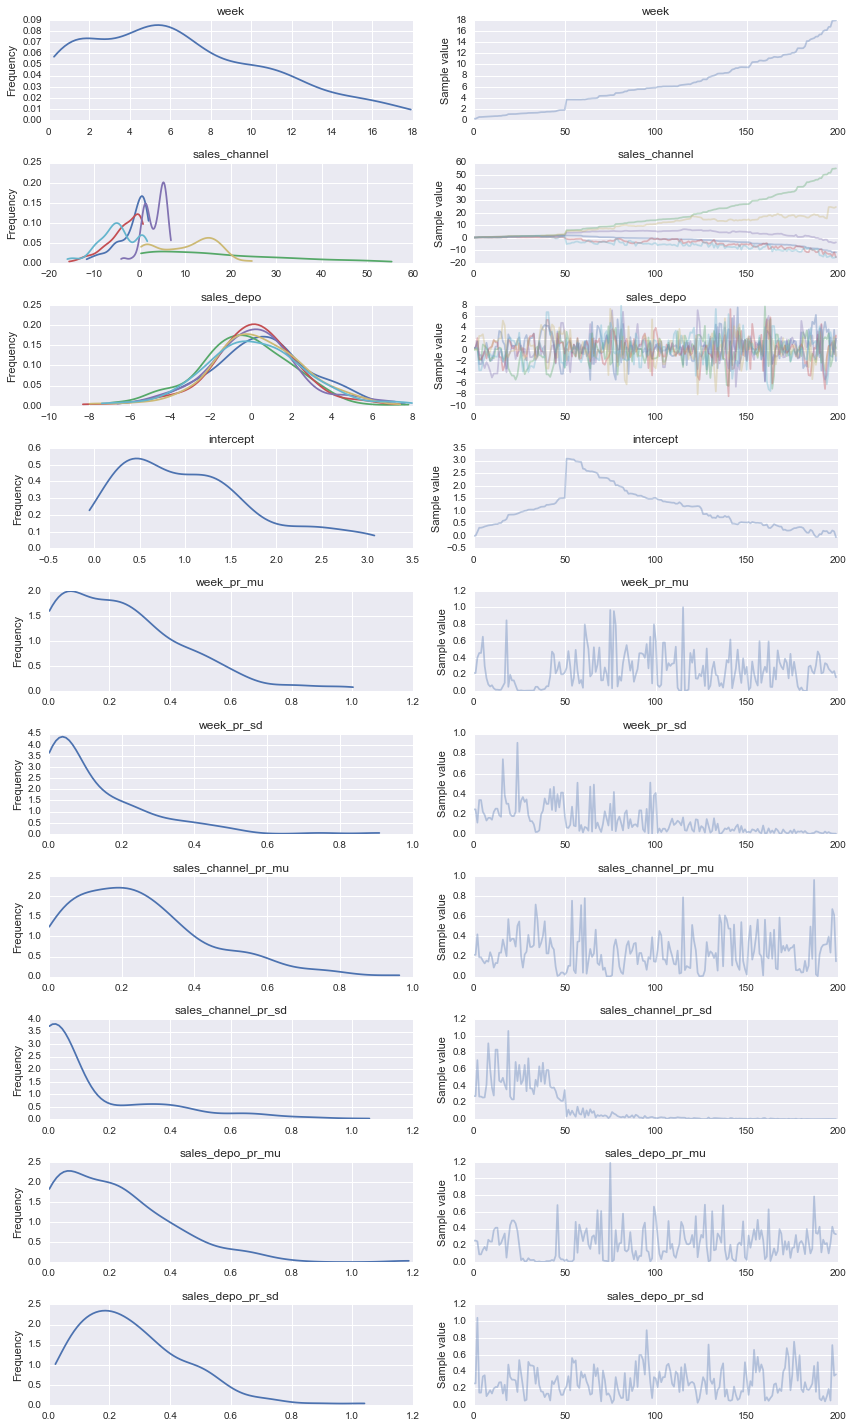

In [9]:
with simple_model:
    trace = pymc3.sample(200, step=pymc3.NUTS())
    pymc3.traceplot(trace)

In [21]:
def create_minibatch(data):
    rng = np.random.RandomState(0)

    while True:
        ixs = rng.randint(len(data), size=5000)
        yield data[ixs]

minibatches = [
    create_minibatch(data.week_num.cat.codes.values),
    create_minibatch(data.sales_channel.cat.codes.values),
    create_minibatch(data.sales_depo.cat.codes.values),

    create_minibatch(data.adjusted_demand.values)
]

def minibatcher():
    while True:
        sample = data.sample(5000)
        yield [
            sample.week_num.cat.codes.values,
            sample.sales_channel.cat.codes.values,
            sample.sales_depo.cat.codes.values,
            sample.adjusted_demand.values,
        ]
        
minibatch_tensors = [week_var,
                     sales_chans_var, 
                     sales_depo_var,
                     adj_demand_var]


In [23]:
with simple_model:
    v_params = pymc3.variational.advi_minibatch(
        n=50000,
        minibatch_tensors=minibatch_tensors,
        minibatch_RVs=[adjusted_demand],
        minibatches=minibatches,
        total_size=data.shape[0], 
        learning_rate=1e-2, 
        epsilon=1.0
    )
    trace = pymc3.variational.sample_vp(v_params, draws=5000)

    pymc3.traceplot(trace)

TypeError: Cannot use a shared variable (week_var) as explicit input. Consider substituting a non-shared variable via the `givens` parameter